In [ ]:
 # Connect & Load from grive
from google.colab import drive
drive.mount('/content/drive')

#Check the files in the direcotory
!ls "/content/drive/MyDrive/Tesla Stock Price - Project"

Mounted at /content/drive
'Tesla.csv - Tesla.csv.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder, normalize
from pandas.plotting import scatter_matrix
from collections import Counter

# Models valuation / train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report,  roc_curve,auc, roc_auc_score

# MC
import math

#Eval Metrics
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.metrics import roc_curve, auc

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Functions

Data Analysis Functions

In [ ]:
def dist_box_plt(df):
    st = time.time()

    for col in df.columns:

        if len(df[col].unique()) > 1 and  df[col].dtypes != 'object':
            fig, ax = plt.subplots(1, 2, figsize=(8,3))
            # distrubution plot
            sns.histplot(data=df, x=col, ax=ax[0], color='r')
            ax[0].set_title(f'Density Plot {col}', fontsize=14)
            # Boxplot
            sns.boxplot(data=df, x=col, ax=ax[1], color='blue')
            ax[1].set_title(f'Box Plot {col}', fontsize=14)
            plt.show()


In [ ]:
def correlations(df, threshold = 0.5, heat_plot = False, cor_plot = False):

    #Correlation with Pearson
    correlation_matrix = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(np.bool))
    corr_mat = correlation_matrix.stack().reset_index(name="correlation")
    print('> Pearson Correlation')

    # Store the high correlated attributes
    score, atr1, atr2 = [], [], []
    for attr1 in df.columns:
        for attr2 in df.columns:
            if attr1 != attr2:
                corr = correlation_matrix.loc[attr1, attr2]
                if corr > threshold:
                    atr1.append(attr1)
                    atr2.append(attr2)
                    score.append(corr)

    score_df = pd.DataFrame({'Attr1':atr1, 'Attr2':atr2, 'Correlation':score})
    print(score_df)
    #Visualize Heatmap
    if heat_plot ==True:
        # Draw each cell as a scatter point with varying size and color
        g = sns.relplot(
            data=corr_mat,
            x="level_0", y="level_1", hue="correlation", size="correlation",
            palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
            height=10, sizes=(50, 250), size_norm=(-.2, .8),
        )
        # Tweak the figure to finalize
        g.set(xlabel="", ylabel="", aspect="equal")
        g.despine(left=True, bottom=True)
        g.ax.margins(.02)
        for label in g.ax.get_xticklabels():
            label.set_rotation(90)
        plt.show()

    #Visualize correlation plot
    if cor_plot == True:
        fig, axes = plt.subplots(20, 5, figsize=(16, 20))
        for col1, col2, s, ax in zip(score_df['Attr1'], score_df['Attr2'],score_df['Correlation'] ,axes.flatten()):
            ax.scatter(df[col1],df[col2])
            ax.set_title(f'Corr:{round(s,2)}')
            plt.subplots_adjust(wspace=.7, hspace=.7)
        plt.show()

    return corr_mat, score_df

In [ ]:
def variance_filtering(df, threshold, bar_plt):
    # Identify the features with high variance. NOTE: the dataset is not standarize or normalized.
    # The dataset is normalized in the function ONLY.

    norm_data = normalize(df) # normalize data
    norm_df =  pd.DataFrame(norm_data, columns=df.columns) # dataframe of normalize data
    variance = norm_df.var() # variance of the df
    lst_tuples_var = list(zip(variance, variance.index)) # store the variance & columns in tuples
    lst_tuples_var.sort(key=lambda x: x[0], reverse=True) # sort the tuples by var - score
    score_lst = [i for i in lst_tuples_var if i[0]> threshold]  # store the features with score higher than the threshold

    # Details  of the Variance score
    print('============ Variance Filtering =======')
    high_feat = [ i[1] for i in score_lst ]
    high_score = [ i[0] for i in score_lst ]
    score_dict = {'Features':high_feat, f'Scores>{threshold}':high_score}
    df_score = pd.DataFrame(score_dict)
    print(tabulate(df_score, headers = 'keys', tablefmt = 'psql'))

    #Plot Variance score
    if bar_plt:
        var_scores_sort = [i[0] for i in lst_tuples_var]
        var_features_sort = [i[1] for i in lst_tuples_var]

        plt.figure(figsize=(10,5))
        plt.bar(var_features_sort,var_scores_sort )
        plt.plot(var_features_sort,var_scores_sort, color = 'red')
        plt.axhline(y = threshold, color = 'green')
        plt.xticks(rotation=90)
        plt.text(x= -3.5, y = threshold, s=f'threshold:\n{threshold}', color = 'black')
        plt.ylabel('Variance')
        plt.xlabel(f'Features {len(var_features_sort)}')
        plt.title(f'Variance Filtering, {len(score_lst)} selected Features ')
        plt.show()

    return score_lst

In [ ]:
def data_details(df):
    # This function Visualize the details of a column, such as type, (min, max)
    #std, mean, Dtype
    cols, atr_val, types, col_mean, col_min_max, col_std, col_index = [], [], [], [], [], [], []

    for col in df.columns:
        cols.append(col)
        atr_val.append(len(df[col].unique()))
        types.append(df[col].dtypes)
        if df[col].dtypes != 'object':
          col_index.append(col)
          col_mean.append(round(df[col].mean(), 2))
          col_min_max.append( (round(df.max()[col],2), round(df.min()[col],2)) )
          col_std.append(round(df[col].std(),2))

    detail_main = {'Columns':cols, 'Value counts':atr_val, 'Dtype':types}
    detail_stats = {'Mean':col_mean, 'Min Max':col_min_max, 'Std': col_std}

    df_detail = pd.DataFrame(detail_main)
    df_stats = pd.DataFrame(detail_stats, index = col_index)

    print(tabulate(df_detail, headers = 'keys', tablefmt = 'psql'))
    print(tabulate(df_stats, headers = 'keys', tablefmt = 'psql'))

In [ ]:
def cross_corr(tm1, tm2, cros_cor_vis = True):
  x, y   = tm1.values, tm2.values
  # Compute the mean of the time series
  mean_x, mean_y = np.mean(x), np.mean(y)
  # Subtract the mean
  x = x - mean_x
  y = y - mean_y

  # Compute the cross-correlation
  ccf = np.correlate(x, y, mode='full') / (np.std(x) * np.std(y))
  # Compute the lag values for the cross-correlation
  lags = np.arange(-len(x) + 1, len(x))
  mean = (ccf.max() - ccf)/ (ccf.max() - ccf.min())

  mean_serie = pd.Series(mean, index = lags)
  max_ind = mean_serie.idxmax()
  max_val = mean_serie.max()
  mean_mean_serie = round(sum(mean_serie)/ len(mean_serie), 2)

  if cros_cor_vis:
    fig, ax = plt.subplots(2,1,figsize = (10,5))

    # Plot the cross-correlation
    ax[0].plot(tm1, 'b--')
    ax[0].plot(tm2, 'r--')
    ax[1].scatter(lags, mean,  facecolors='none',edgecolors='blue' )
    ax[1].axhline(y = max_val, color = 'black', linestyle = 'dashed', label = 'Higher point')
    ax[1].axvline(x = max_ind, color = 'black', linestyle = 'dashed')
    ax[0].set_xlabel('Years')
    ax[0].set_ylabel('Value')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Cross-correlation')
    ax[0].set_title("{} (blue) and {} (red)".format(tm1.name, tm2.name))
    ax[1].set_title('Cross-correlation between {} and {} mean Ccor score {}'.format(tm1.name, tm2.name, mean_mean_serie))
    fig.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
def comparison_plot(df, cols):
  # Compare the Columns behaivior
  plt.figure(sharex=True, figsize=(12, 5))
  ax = sns.lineplot(data=df,x="Date",y=cols[0],color="red",label=cols[0])
  ax = sns.lineplot(data=df,x="Date",y=cols[1],color="blue",label=cols[1])
  #ax.get_xaxis().set_visible(False)
  plt.title(f'Tesla {cols[0]} and {cols[1]} ')
  plt.xlabel('Dates')
  plt.ylabel('Prices')
  plt.show()

Moving Average

In [ ]:
def MA(df, col, past_n):
    # Visualize the MOving Average of a column
    colors = ['red', 'blue', 'green', 'orange']
    for (i, n) in enumerate(past_n):
      ma = df[col].rolling(n).mean()
      plt.plot(df['Date'], ma, color=colors[i], label="MA{} ({})".format(n, colors[i].upper()))

    plt.legend(loc='best')
    plt.title("Stock Moving Averages")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.show()

Monte Carlo/Random Walks

In [ ]:
def MC(data, col, sims=5, maxdrawdown=-0.1, goal=1):
  # MC Random Walks
  mc = data[col].montecarlo(sims=sims, bust=maxdrawdown, goal=goal)
  # MC Simulaitons
  random_walks = data[col].pct_change().montecarlo(sims=sims, bust=maxdrawdown, goal=goal)
  #plots
  random_walks.plot(title=f"{col} Monte Carlo Simulations")
  main_lst = []
  # for all the columns in the simulations (sim1, sim2, sim3..., simN)
  #append all the values in to a list
  for i in mc.data.iloc[:,1:].columns:
    for val in mc.data.iloc[:,1:][i].values:
      main_lst.append(val)

  return main_lst


Machine Learning

In [ ]:
def plot_roc_curve(X_test, y_test, model, model_name="Classifier"):
     #Visualize The ROC Curve of a ML Model
     # The line below is equivalent to
     y_predicted = model.predict(X_test)
     # The line below is equivalent to
     y_predicted_proba = getattr(model, "predict_proba")(X_test)
     auc_roc_log_reg = roc_auc_score(y_test, y_predicted)
     fpr, tpr, thresholds = roc_curve(y_test, y_predicted_proba[:,1])

     plt.plot(fpr, tpr, color="red", lw=2,
              label=f"{model_name} (area = {auc_roc_log_reg:0.5f})")
     plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--",
              label="Mean model (area = 0.500)")
     plt.xlim([0.0, 1.0])
     plt.ylim([0.0, 1.05])
     plt.xlabel("False Positive Rate")
     plt.ylabel("True Positive Rate")
     plt.title("Receiver operating characteristic")
     plt.legend(loc="lower right")
     plt.show()

     # Calculate the auc score
     auc_score = auc(fpr, tpr)
     print(f"auc_score: {round(auc_score, 3)}.")

In [ ]:
def eval_metrics(y_test, y_pred):
  # Evaluate the model's accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  con_matr = confusion_matrix(y_test, y_pred)
  # print("Accuracy:", round(accuracy,2))
  # print("Precision: ", round(precision,2))
  # print("Recall: ", round(recall,2))
  # print("F1-Score: ", round(f1,2))
  print(f'Confusion Matrix\n {con_matr}')
  eval_lst = [round(accuracy,2), round(precision,2), round(recall,2), round(f1,2)]
  return eval_lst

In [ ]:
def ML_models(models, names, X_train, y_train, X_test, y_test):
  #Variables
  y_predictions =[]
  eval_dict = {}

  # Comparison of the ML models
  for model, name in zip(models, names):
    print(f'====== {name} =====')
    # Train the decision tree on the training data
    model.fit(X_train, y_train)
    # predictions on the test data
    y_pred = model.predict(X_test)
    #Store the prediction
    y_predictions.append( (str(name),y_pred) )
    #Evaluation Metrics of the model
    eval_lst = eval_metrics(y_test, y_pred)
    eval_dict[name] = eval_lst

  return eval_dict, y_predictions

In [ ]:
def ROC_curve_com(y_predictions, y_test):
  #Visualize the ROC of al the ML models
  for pred in y_predictions: # For every prediction (model) plot the ROC curve
    model_name, pred_vals = pred[0], pred[1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
    roc_auc = auc(fpr, tpr)
    label = f'{model_name} ROC curve (area = {round(roc_auc, 2)})'
    plt.plot(fpr, tpr, label=label)


  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# Main

## Data Describe



* The date - **"Date"**

* The opening price of the stock - **"Open"**

* The high price of that day - **"High"**

* The low price of that day - **"Low"**

* The closed price of that day - **"Close"**

* The amount of stocks traded during that day - **"Volume"**

* The stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open - **"Adj Close"**



In [ ]:
path =  "/content/drive/MyDrive/Tesla Stock Price - Project/Tesla.csv - Tesla.csv.csv"
data = pd.read_csv(path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

In [ ]:
print(f'Data Shape: {data.shape}')
print(f'Null values: {data.isnull().sum().sum()}')
print(f'Duplicated values: {data.duplicated().sum()}')

Data Shape: (1692, 6)
Null values: 0
Duplicated values: 0


In [ ]:
data_details(data)

+----+-----------+----------------+---------+
|    | Columns   |   Value counts | Dtype   |
|----+-----------+----------------+---------|
|  0 | Open      |           1464 | float64 |
|  1 | High      |           1470 | float64 |
|  2 | Low       |           1468 | float64 |
|  3 | Close     |           1528 | float64 |
|  4 | Volume    |           1676 | int64   |
|  5 | Adj Close |           1528 | float64 |
+----+-----------+----------------+---------+
+-----------+---------------+------------------------+--------------+
|           |          Mean | Min Max                |          Std |
|-----------+---------------+------------------------+--------------|
| Open      | 132.44        | (287.67, 16.14)        | 94.31        |
| High      | 134.77        | (291.42, 16.63)        | 95.69        |
| Low       | 130           | (280.4, 14.98)         | 92.86        |
| Close     | 132.43        | (286.04, 15.8)         | 94.31        |
| Volume    |   4.27074e+06 | (37163900.0, 118500.

## Target

***Train a ML/ DL model to Predict if tommorow price is higher than todays price***

Steps
 Create a column named 'Next day/ tommrow

1.   Create target column by identifing if the Tommorow price is higher than the Todays price. Next day price > Todays price
2.   Note that the price we are searching is the **closing** day





In [ ]:
data['Next Day'] = data['Close'].shift(-1)
data['Target'] = (data['Next Day'] > data['Close']).astype(int)
data = data.drop(['Next Day'], axis=1) # drop the column since are the sam as close col

In [ ]:
data['Target'].value_counts()

1    866
0    826
Name: Target, dtype: int64

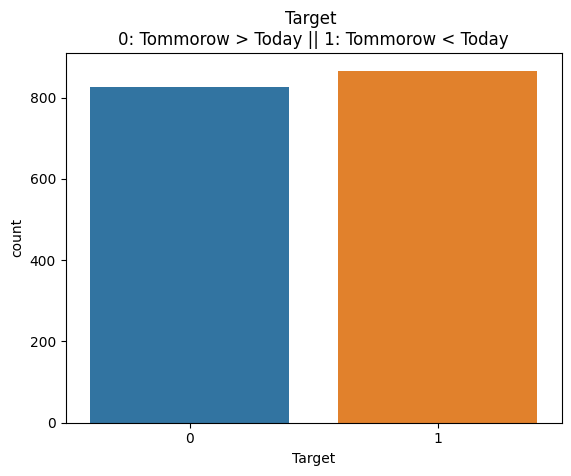

In [ ]:
sns.countplot(data = data, x = 'Target')
plt.title('Target \n0: Tommorow > Today || 1: Tommorow < Today')
plt.show()

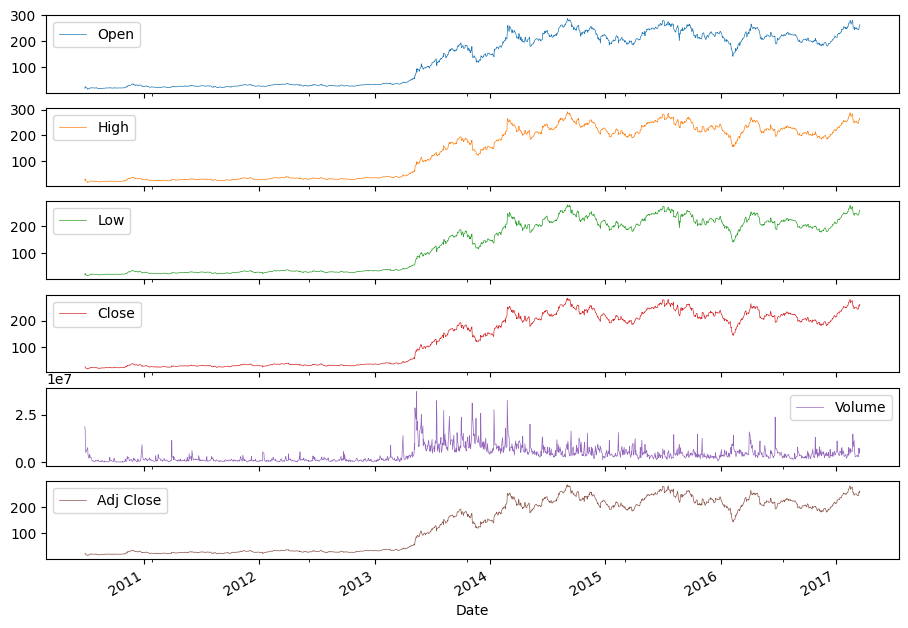

In [ ]:
data[['Open',	'High',	'Low',	'Close',	'Volume',	'Adj Close']].plot(subplots = True, linewidth = 0.5, figsize=(11, 8))
plt.show()

## Correlations/ Data Analysis

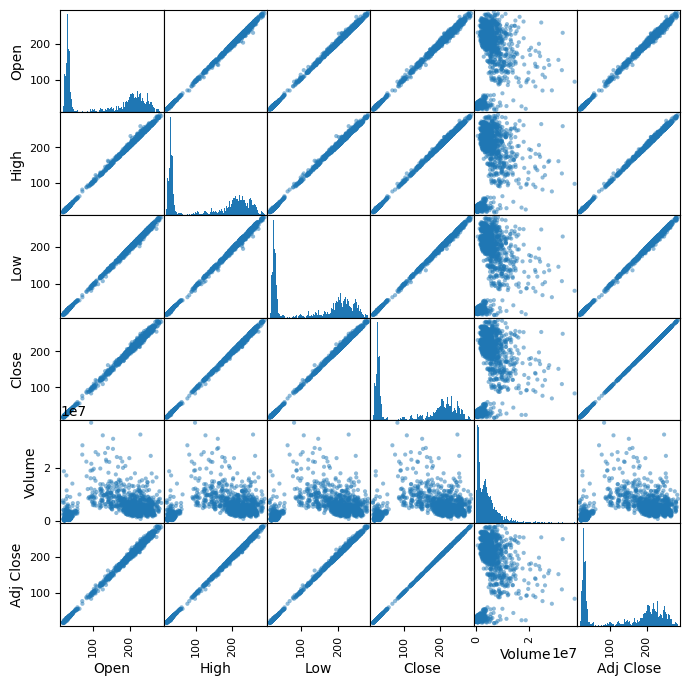

In [ ]:
scatter_matrix(data[['Open',	'High',	'Low',	'Close',	'Volume',	'Adj Close']],
               figsize = (8,8),
               hist_kwds= {'bins':100})
plt.show()

In [ ]:
#dist_box_plt(data[['Open',	'High',	'Low',	'Close',	'Volume',	'Adj Close', 'Target']])

In [ ]:
# Create
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']
data_numeric = data[numeric_cols]
data_numeric = data_numeric.dropna()
cors = correlations(data_numeric)

> Pearson Correlation
   Attr1      Attr2  Correlation
0   Open       High     0.999623
1   Open        Low     0.999605
2   Open      Close     0.999233
3   Open  Adj Close     0.999233
4   High        Low     0.999521
5   High      Close     0.999691
6   High  Adj Close     0.999691
7    Low      Close     0.999656
8    Low  Adj Close     0.999656
9  Close  Adj Close     1.000000


<ipython-input-4-a3cbf0b62c46>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlation_matrix = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(np.bool))


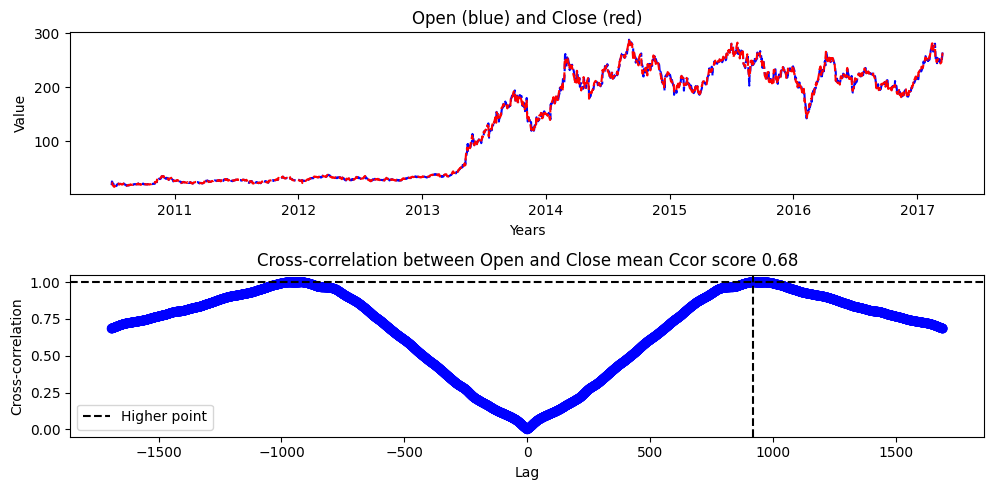

In [ ]:
cross_corr(data['Open'], data['Close'])

In [ ]:
variance_filtering(data_numeric, threshold = 0.01, bar_plt= False)
# Indicaitndg that all features have low variance

============ Variance Filtering =======
+------------+---------------+
| Features   | Scores>0.01   |
|------------+---------------|
+------------+---------------+


[]

## Moving Average Dataset

In [ ]:
data_MA = data.copy()

In [ ]:
# Implimenting Moving average on the dataset
ma_day = [10, 20, 30,50]
for ma in ma_day:
    for atr in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
        column_name = f"{atr} MA for {ma} days"
        data_MA[column_name] = data_MA[atr].rolling(ma).mean()

In [ ]:
data_MA.shape

(1692, 31)

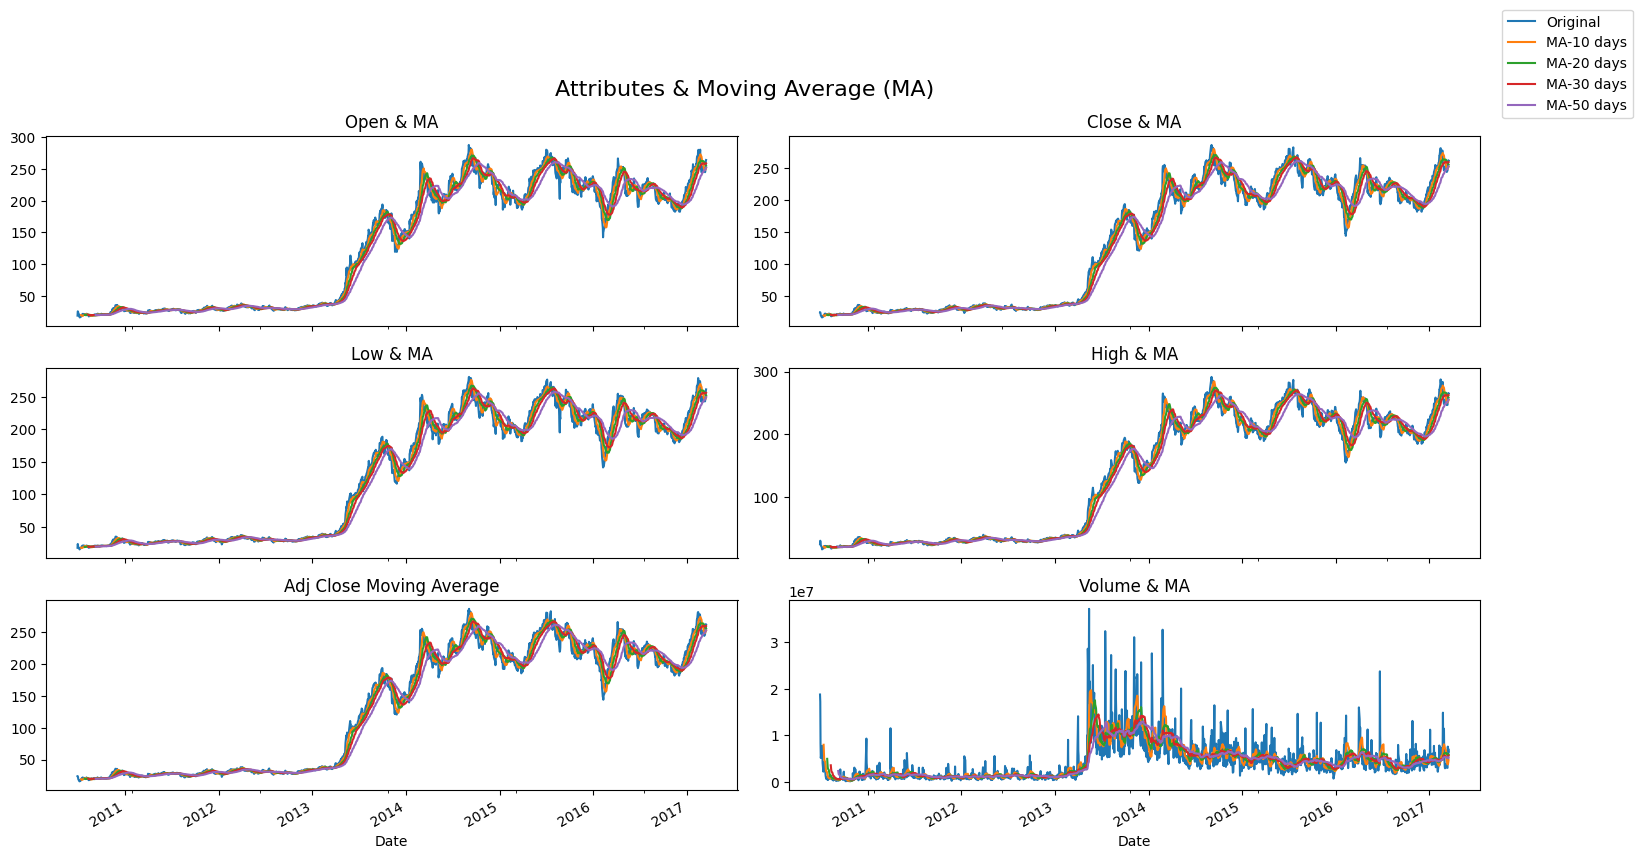

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(15,8), sharex = True)

data_MA[['Open', 'Open MA for 10 days', 'Open MA for 20 days', 'Open MA for 30 days', 'Open MA for 50 days']].plot(ax=axes[0,0],legend = False )
axes[0,0].set_title('Open & MA')

data_MA[['Close', 'Close MA for 10 days', 'Close MA for 20 days', 'Close MA for 30 days','Close MA for 50 days']].plot(ax=axes[0,1],legend = False)
axes[0,1].set_title('Close & MA')

data_MA[['Adj Close', 'Adj Close MA for 10 days', 'Adj Close MA for 20 days', 'Adj Close MA for 30 days','Adj Close MA for 50 days']].plot(ax=axes[2,0],legend = False)
axes[2,0].set_title('Adj Close Moving Average')

data_MA[['Low', 'Low MA for 10 days', 'Low MA for 20 days', 'Low MA for 30 days', 'Low MA for 50 days']].plot(ax=axes[1,0],legend = False)
axes[1,0].set_title('Low & MA')

data_MA[['High', 'High MA for 10 days', 'High MA for 20 days', 'High MA for 30 days','High MA for 50 days']].plot(ax=axes[1,1],legend = False)
axes[1,1].set_title('High & MA')

data_MA[['Volume', 'Volume MA for 10 days', 'Volume MA for 20 days', 'Volume MA for 30 days','Volume MA for 50 days']].plot(ax=axes[2,1],legend = False)
axes[2,1].set_title('Volume & MA')

fig.legend( labels=['Original','MA-10 days', 'MA-20 days', 'MA-30 days','MA-50 days'],
          loc="center left", bbox_to_anchor=(1,1))
fig.suptitle('Attributes & Moving Average (MA)', fontsize=16)
fig.tight_layout()

ML models with MA dataset

In [ ]:
data_MA_all =data_MA.copy().dropna()
print(f'The shape of the dataset with ALL MA {data_MA_all.shape}.\nStarting data:{data_MA_all.index[0]}.\nEnd Date: {data_MA_all.index[len(data_MA_all.index)-1]} \n')

The shape of the dataset with ALL MA (1643, 31).
Starting data:2010-09-08 00:00:00.
End Date: 2017-03-17 00:00:00 



In [ ]:
X = data_MA_all.drop(['Target'],axis=1)
y = data_MA_all['Target'].values

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train:{X_train.shape}....y_train:{y_train.shape}\nX_test{X_test.shape}....y_test:{y_test.shape}')

X_train:(1314, 30)....y_train:(1314,)
X_test(329, 30)....y_test:(329,)


In [ ]:
names = ['RF', 'DT', 'XGB', 'Gaussian', 'SVM']
models = [RandomForestClassifier(), DecisionTreeClassifier(),
          XGBClassifier() , GaussianNB(), SVC(probability=True)]

eval_dict, y_predictions = ML_models(models, names, X_train, y_train, X_test, y_test)

====== RF =====
Confusion Matrix
 [[93 67]
 [80 89]]
====== DT =====
Confusion Matrix
 [[88 72]
 [79 90]]
====== XGB =====
Confusion Matrix
 [[93 67]
 [80 89]]
====== Gaussian =====
Confusion Matrix
 [[ 57 103]
 [ 62 107]]
====== SVM =====
Confusion Matrix
 [[ 13 147]
 [  9 160]]


In [ ]:
results_df = pd.DataFrame(eval_dict, index = ['Acc', 'Precision', 'Recall', 'F1-Score'])
print(tabulate(results_df, headers = 'keys', tablefmt = 'psql'))

+-----------+------+------+-------+------------+-------+
|           |   RF |   DT |   XGB |   Gaussian |   SVM |
|-----------+------+------+-------+------------+-------|
| Acc       | 0.55 | 0.54 |  0.55 |       0.5  |  0.53 |
| Precision | 0.57 | 0.56 |  0.57 |       0.51 |  0.52 |
| Recall    | 0.53 | 0.53 |  0.53 |       0.63 |  0.95 |
| F1-Score  | 0.55 | 0.54 |  0.55 |       0.56 |  0.67 |
+-----------+------+------+-------+------------+-------+


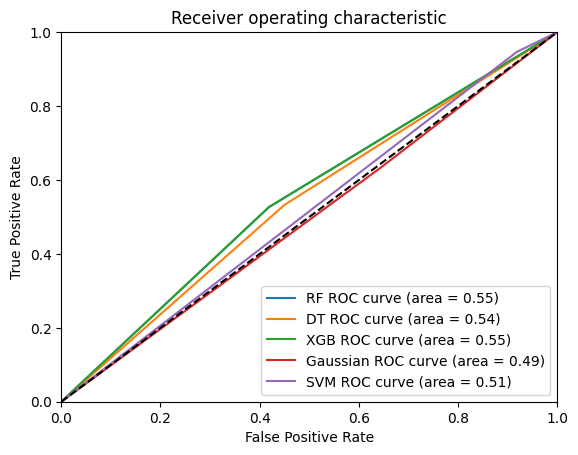

In [ ]:
ROC_curve_com(y_predictions, y_test)

## Monte Carlo dataset

https://www.youtube.com/watch?v=f9MAFvP5-pA&list=PLqpCwow11-OqqfELduCMcRI6wcnoM3GAZ&index=3


https://www.youtube.com/watch?v=6-dhdMDiYWQ&list=PLqpCwow11-OqqfELduCMcRI6wcnoM3GAZ&index=2

https://www.analyticsvidhya.com/blog/2021/07/a-guide-to-monte-carlo-simulation/


Code:
* https://sidhanthk9.medium.com/predicting-stock-prices-using-monte-carlo-simulation-dae4c3fec02a#:~:text=In%20trading%2C%20Monte%20Carlo%20Simulation,by%20evaluating%20potential%20future%20performance.
* https://runawayhorse001.github.io/LearningApacheSpark/mc.html


https://medium.com/@nielsencastelodamascenodantas/monte-carlo-forecast-using-python-a9de91a742c3

In [ ]:
#!pip install pandas_montecarlo --upgrade --no-cache-dir
import pandas_montecarlo

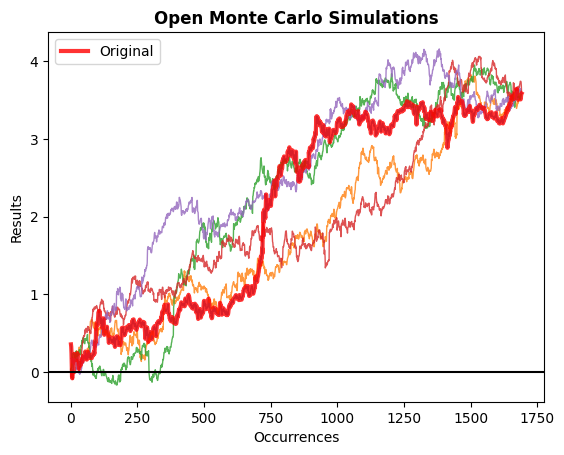

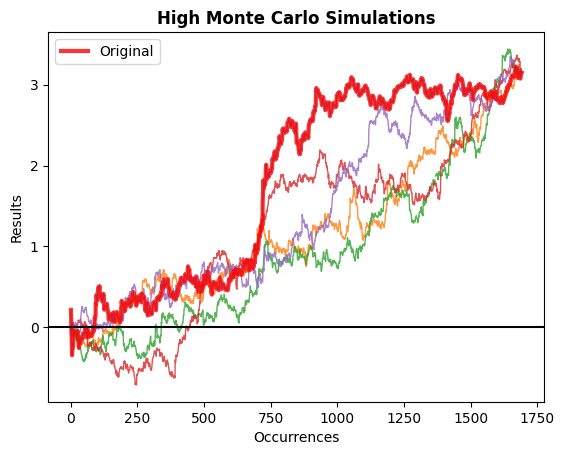

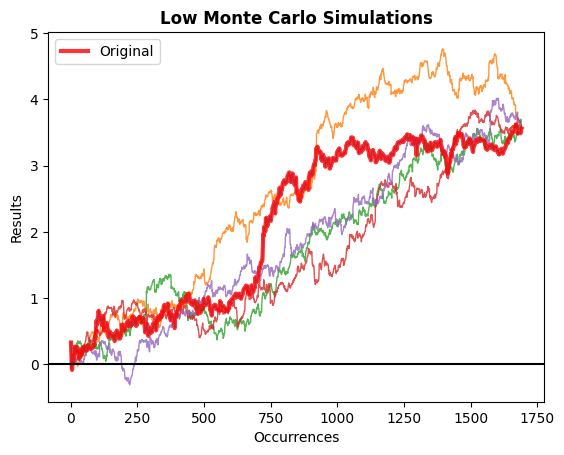

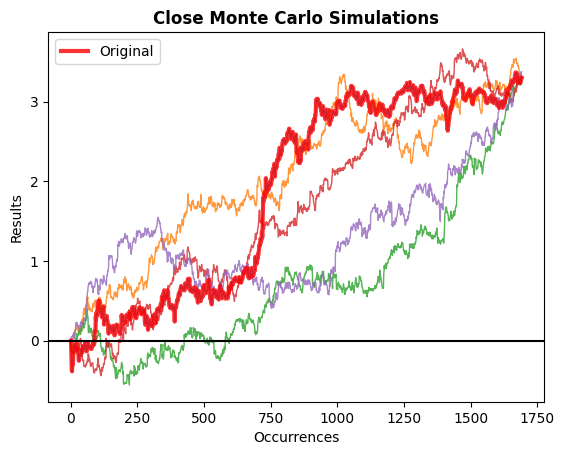

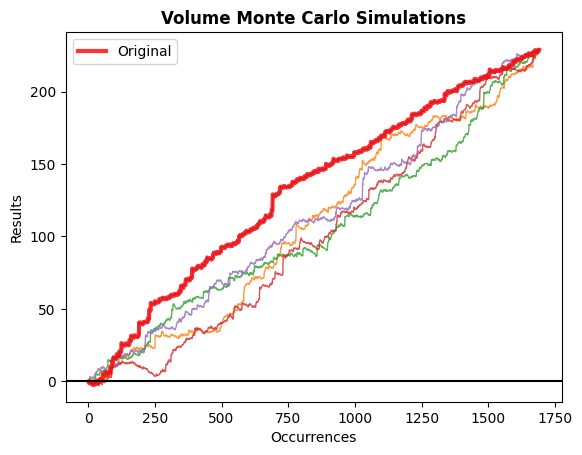

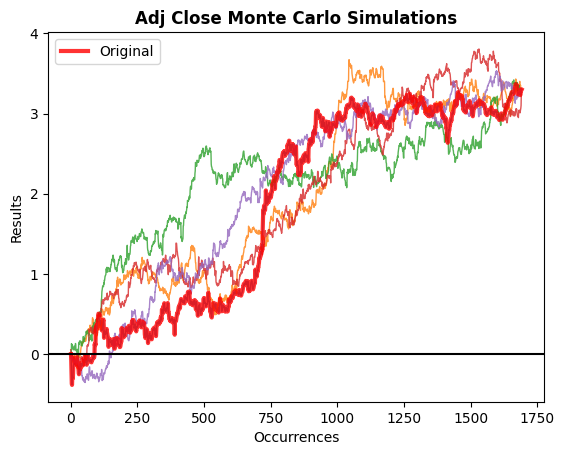

In [ ]:
# Create a dataframe and Store the MOne Carlo/Random Walks Simulations
dict_MC = {}
for col in data.columns[:-1]: # exept the Target Column
  MC_lst = MC(data, col, sims =5)
  dict_MC[col] = MC_lst

In [ ]:
MC_df = pd.DataFrame(dict_MC) # MOnte Carlo DataFrame
# Create the Target Column
MC_df['Next Day'] = MC_df['Close'].shift(-1)
MC_df['Target'] = (MC_df['Next Day'] > MC_df['Close']).astype(int)
MC_df = MC_df.drop(['Next Day'], axis=1) # drop the column since are the sam as close col
print(f'Data Shape{MC_df.shape}')

Data Shape(6768, 7)


In [ ]:
# Merge The datasets (Generated from Random Walks and  original)
merge_data = pd.concat([data, MC_df])
merge_data = merge_data.reset_index()
merge_data = merge_data.drop(['index'], axis=1)
print(f'Data Shape{merge_data.shape}')

Data Shape(16920, 7)


In [ ]:
1643, 25

In [ ]:
X_MC = merge_data.drop(['Target'],axis=1)
y_MC = merge_data['Target'].values

X_train_MC, X_test_MC, y_train_MC, y_test_MC = train_test_split(X_MC, y_MC, test_size=0.2, random_state=42)
print(f'X_train:{X_train_MC.shape}....y_train:{y_train_MC.shape}\nX_test{X_test_MC.shape}....y_test:{y_test_MC.shape}')

X_train:(13536, 6)....y_train:(13536,)
X_test(3384, 6)....y_test:(3384,)


In [ ]:
names = ['RF', 'DT', 'XGB', 'Gaussian', 'SVM']
models_MC = [RandomForestClassifier(), DecisionTreeClassifier(),
          XGBClassifier() , GaussianNB(), SVC(probability=True)]

# Evauation Metrics of the models
eval_dict_MC, y_predictions_MC = ML_models(models_MC, names, X_train_MC,  y_train_MC, X_test_MC,y_test_MC)

====== RF =====
Confusion Matrix
 [[1229  453]
 [ 477 1225]]
====== DT =====
Confusion Matrix
 [[1096  586]
 [ 603 1099]]
====== XGB =====
Confusion Matrix
 [[1182  500]
 [ 471 1231]]
====== Gaussian =====
Confusion Matrix
 [[1294  388]
 [ 509 1193]]
====== SVM =====
Confusion Matrix
 [[1239  443]
 [1269  433]]


In [ ]:
# Table of Results
results_df_MC = pd.DataFrame(eval_dict_MC, index = ['Acc', 'Precision', 'Recall', 'F1-Score'])
print(tabulate(results_df_MC, headers = 'keys', tablefmt = 'psql'))

+-----------+------+------+-------+------------+-------+
|           |   RF |   DT |   XGB |   Gaussian |   SVM |
|-----------+------+------+-------+------------+-------|
| Acc       | 0.73 | 0.65 |  0.71 |       0.73 |  0.49 |
| Precision | 0.73 | 0.65 |  0.71 |       0.75 |  0.49 |
| Recall    | 0.72 | 0.65 |  0.72 |       0.7  |  0.25 |
| F1-Score  | 0.72 | 0.65 |  0.72 |       0.73 |  0.34 |
+-----------+------+------+-------+------------+-------+


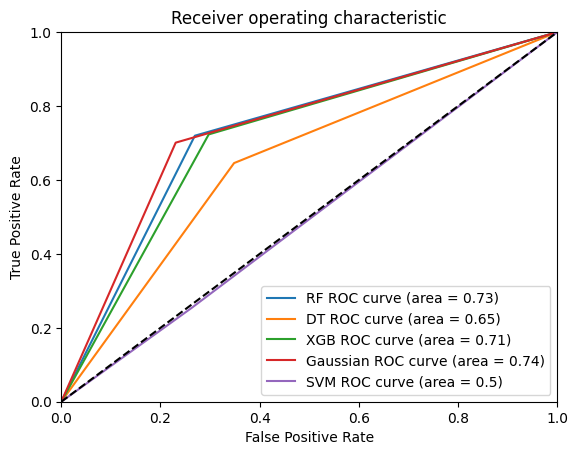

In [ ]:
# ROC Curve
ROC_curve_com(y_predictions_MC, y_test_MC)

### MC Function 2

[CAGR Definition:](https://www.vertex42.com/Calculators/cagr-calculator.html) The CAGR formula is commonly defined as CAGR = (End Value/Start Value)^(1/Years)-1.



```
days =  (stock.Date.iloc[-1] - stock.Date.iloc[0]).days
cagr = ((((stock['Adj Close'].iloc[-1]) / stock['Adj Close'].iloc[0])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr
```



In [ ]:
# one traidng year has ~252
start_year, end_year, step = 0, 253, 253
print(f'Start Year:{data.index[start_year]}\nEnd Year:{data.index[end_year]}\nStep:{step}')
print(f'Difference in Days: {(data.index[end_year]-data.index[start_year]).days}')
# calculate the number of days that have elapsed in our chosen time window


In [ ]:
def MC_sim(data, col, number_of_trials):
  time_elapsed = (data.index[-1] - data.index[0]).days
  print(f'Days: {time_elapsed}')
  # Variables
  total_growth = (data[col][-1] / data[col][1])
  number_of_years = time_elapsed / 365.0
  cagr = total_growth ** (1/number_of_years) - 1
  std_dev = data[col].pct_change().std()
  number_of_trading_days = 252
  std_dev = std_dev * math.sqrt(number_of_trading_days)
  random_walks = {}
  closing_prices = []

  print ("CAGR-(mean returns) : ", str(round(cagr,4)))
  print ("standard deviation of return:", str(round(std_dev,4)))

  for i in range(number_of_trials):
      #calculate randomized return percentages following our normal distribution
      #and using the mean / std dev we calculated above
      daily_return_percentages = np.random.normal(cagr/number_of_trading_days,
                                                  std_dev/math.sqrt(number_of_trading_days),
                                                  int(number_of_trading_days*number_of_years))+1
      price_series = [data[col][-1]]
      for j in daily_return_percentages:
          #extrapolate price out for next day
          price_series.append(price_series[-1] * j)

      #append closing prices in last day of window for histogram
      #closing_prices.append(price_series[-1])
      random_walks[i] = price_series
      #plot all random walks
      plt.plot(price_series)
  plt.title(f'Random Walks for {col}')
  plt.show()

  df_random_walks = pd.DataFrame(random_walks)
  main_lst =[]
  for i in df_random_walks.columns:
    for val in df_random_walks.iloc[:,:][i].values:
      main_lst.append(val)

  return  main_lst
